# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

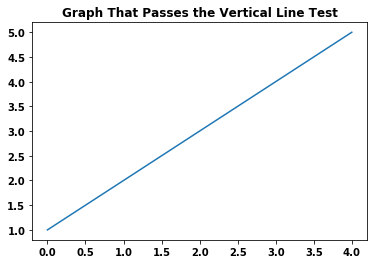

In [3]:
x_vals = [0, 1, 2, 3, 4]
y_vals = [1, 2, 3, 4, 5]

plt.plot(x_vals, y_vals)
plt.title('Graph That Passes the Vertical Line Test')
plt.show()

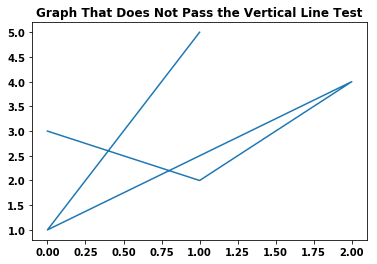

In [5]:
x_vals = [0, 1, 2, 0, 1]
y_vals = [3, 2, 4, 1, 5]

plt.plot(x_vals, y_vals)
plt.title('Graph That Does Not Pass the Vertical Line Test')
plt.show()

## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

### Because there are inputs with multiple outputs, so it is ambiguous.

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

### Relation 2 is the only function because it doesn't have more than 1 output for a given input.

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

### m(x1, x2, x3) is 3 dimensional and its output is 3 dimensional.

### n(x1, x2, x3, x4) is 4 dimensional and its output is 2 dimensional.

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

### No, this is not possible. The lower dimensional space doesn't have the points in its space to reach a higher dimension. For instance, a 1-dimensional vector can only scale up and down a straight line no matter what scalar you use. 

# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

In [10]:
p_T = [[1, 3],
        [-1, 2]]

q_T = [[4, 1, 2],
        [-1, 2, 3],
        [5, 1, -2]]


## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

In [11]:
v = [3, 4]
w = [2, 1, 3]

print(np.matmul(p_T, v))
print(np.matmul(q_T, w))

[15  5]
[15  9  5]


\begin{align}
p(\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} 3 + 3*4 \\ -3 + 2*4 \end{bmatrix}
\end{align}

\begin{align}
p(\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} 15 \\ 5 \end{bmatrix}
\end{align}

\begin{align}
q(\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} 4*2 + 1 + 2*3 \\ 
-1*2 + 2*1 + 3*3 \\ 5*2 + 1 + -2*3\end{bmatrix}
\end{align}

\begin{align}
q(\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} 15 \\ 9 \\ 5 \end{bmatrix}
\end{align}

# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

### Eigenvectors are vectors that don't change their direction during a transformation. The vector keeps the same direction (orientation), but can be scaled up or down during the transformation. The eigenvalues are the scalars that scale the eigenvectors during the transformation.

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

### High dimensional spaces increase computational workload, increase sparcity (data points are more spread out), and a low number of obvservations relative to dimensions increases the risk of overfitting.

## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

### You should have 5 times as many observations as features.

# Principal Component Analysis

## 7.1 Load the UCI Machine Learning Repository's [Iris Dataset](https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv) and use PCA to isolate the dataset's first and second principal components and plot them on a graph. 

In [13]:
df = pd.read_csv('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [14]:
# separate data into x and y variables
X = df.drop('species', axis=1)
y = df['species']

X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [16]:
# center each column at 0 by subtracting its mean
X_centered = X - X.mean()
X_centered.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.743333,0.446,-2.358667,-0.998667
1,-0.943333,-0.054,-2.358667,-0.998667
2,-1.143333,0.146,-2.458667,-0.998667
3,-1.243333,0.046,-2.258667,-0.998667
4,-0.843333,0.546,-2.358667,-0.998667


In [19]:
# divide each column by its standard deviation
Z = X_centered / X_centered.std()
Z.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593


In [24]:
# calculate covariance matrix of Z
covariance_matrix = np.cov(Z.T)
covariance_matrix

array([[ 1.        , -0.10936925,  0.87175416,  0.81795363],
       [-0.10936925,  1.        , -0.4205161 , -0.35654409],
       [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ],
       [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ]])

In [25]:
from numpy.linalg import eig

# calculate the eigendecomposition of covariance matrix
values, vectors = eig(covariance_matrix)
print("\n Eigenvectors: \n", vectors)
print("\n Eigenvalues: \n", values)


 Eigenvectors: 
 [[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

 Eigenvalues: 
 [2.91081808 0.92122093 0.14735328 0.02060771]


In [26]:
# project data
P = vectors.T.dot(Z.T)
print("\n Projected Data: \n", P.T)


 Projected Data: 
 [[-2.25698063e+00 -5.04015404e-01 -1.21536190e-01  2.29962838e-02]
 [-2.07945912e+00  6.53216394e-01 -2.26492063e-01  1.02863642e-01]
 [-2.36004408e+00  3.17413945e-01  5.13077379e-02  2.77323192e-02]
 [-2.29650366e+00  5.73446613e-01  9.85303586e-02 -6.60900544e-02]
 [-2.38080159e+00 -6.72514411e-01  2.13563034e-02 -3.72724209e-02]
 [-2.06362348e+00 -1.51347827e+00  3.05818064e-02  4.38408784e-03]
 [-2.43754534e+00 -7.43137171e-02  3.41055070e-01 -3.79693659e-02]
 [-2.22638327e+00 -2.46787172e-01 -8.22987560e-02 -2.54200029e-02]
 [-2.33413810e+00  1.09148977e+00  1.53049668e-01 -2.67043670e-02]
 [-2.18136797e+00  4.47131117e-01 -2.45736283e-01 -3.97740567e-02]
 [-2.15626287e+00 -1.06702096e+00 -2.63127870e-01  1.52500486e-02]
 [-2.31960686e+00 -1.58057946e-01  9.98311719e-02 -1.34104994e-01]
 [-2.21665672e+00  7.06750478e-01 -2.22469221e-01  2.62183044e-03]
 [-2.63090249e+00  9.35149145e-01  1.88937073e-01 -1.93571700e-02]
 [-2.18497165e+00 -1.88366805e+00 -4.67912

In [32]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

# standardize the data
standardize_X = preprocessing.scale(X)

# create the PCA instance
pca = PCA(n_components=2)

# fit on data
pca.fit(np.array(standardize_X))

# access values and vectors
print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n", pca.explained_variance_)

# transform data
B = pca.transform(standardize_X)
print("\n Projected Data: \n", B)


 Eigenvectors: 
 [[ 0.52237162 -0.26335492  0.58125401  0.56561105]
 [ 0.37231836  0.92555649  0.02109478  0.06541577]]

 Eigenvalues: 
 [2.93035378 0.92740362]

 Projected Data: 
 [[-2.26454173e+00  5.05703903e-01]
 [-2.08642550e+00 -6.55404729e-01]
 [-2.36795045e+00 -3.18477311e-01]
 [-2.30419716e+00 -5.75367713e-01]
 [-2.38877749e+00  6.74767397e-01]
 [-2.07053681e+00  1.51854856e+00]
 [-2.44571134e+00  7.45626750e-02]
 [-2.23384186e+00  2.47613932e-01]
 [-2.34195768e+00 -1.09514636e+00]
 [-2.18867576e+00 -4.48629048e-01]
 [-2.16348656e+00  1.07059558e+00]
 [-2.32737775e+00  1.58587455e-01]
 [-2.22408272e+00 -7.09118158e-01]
 [-2.63971626e+00 -9.38281982e-01]
 [-2.19229151e+00  1.88997851e+00]
 [-2.25146521e+00  2.72237108e+00]
 [-2.20275048e+00  1.51375028e+00]
 [-2.19017916e+00  5.14304308e-01]
 [-1.89407429e+00  1.43111071e+00]
 [-2.33994907e+00  1.15803343e+00]
 [-1.91455639e+00  4.30465163e-01]
 [-2.20464540e+00  9.52457317e-01]
 [-2.77416979e+00  4.89517027e-01]
 [-1.82041156

In [34]:
pca_df = pd.DataFrame(B)
pca_df.head()

,0,1
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767


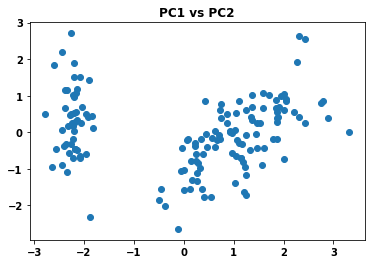

In [36]:
plt.scatter(pca_df[0], pca_df[1])
plt.title('PC1 vs PC2')
plt.show()

# Stretch Goal

## 1) Do NOT work on the stretch goal until you feel like you have a firm grasp of eigenvectors, eigenvalues, and PCA. Prioritize self-study over the stretch goal if you are not comfortable with those topics yet.

## 2) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

<center>![Eigenfaces](https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg)</center>

You don't necessarily have to use this resource, but this will get you started: 
[Eigenface Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)